<a href="https://colab.research.google.com/github/Whatthe-we/AIFFEL_quest_cr/blob/master/%ED%8F%90%EB%A0%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 폐렴아 기다려라! [Project]

## 목차
###1. Set-up
###2. 데이터 가져오기
###3. 데이터 시각화
###4. CNN 모델링
###5. 데이터 imbalance 처리
###6. 모델 훈련 (베이스 모델)
###7. 성능 향상 및 비교
###8. ResNet-18 모델 구현
###회고



# 1. Set-up
---

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
import zipfile
import os
warnings.filterwarnings(action='ignore')

In [11]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = '/content/chest_xray'  # 수정된 부분
TRAIN_PATH = os.path.join(ROOT_PATH, 'train', '*/*')  # train 폴더 내 모든 이미지
VAL_PATH = os.path.join(ROOT_PATH, 'val', '*/*')      # val 폴더 내 모든 이미지
TEST_PATH = os.path.join(ROOT_PATH, 'test', '*/*')    # test 폴더 내 모든 이미지

# 두 변수를 변경
BATCH_SIZE = 32
EPOCHS = 15

print(ROOT_PATH)

/content/chest_xray


# 2. 데이터 가져오기
---

In [12]:
# 데이터셋 kaggle에서 불러오기
os.makedirs('/root/.kaggle', exist_ok=True)  # .kaggle 디렉토리 생성
!mv kaggle.json /root/.kaggle/  # 파일 이동
!chmod 600 /root/.kaggle/kaggle.json  # 보안 권한 설정
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('chest_xray')  # 'chest_xray' 디렉토리에 압축 해제

# chest_xray 경로 내 데이터 경로 설정
ROOT_PATH = '/content/chest_xray/chest_xray' # 수정된 부분: 압축 해제된 폴더 경로를 지정
TRAIN_PATH = os.path.join(ROOT_PATH, 'train', '*/*')  # train 폴더 내 모든 이미지
VAL_PATH = os.path.join(ROOT_PATH, 'val', '*/*')      # val 폴더 내 모든 이미지
TEST_PATH = os.path.join(ROOT_PATH, 'test', '*/*')    # test 폴더 내 모든 이미지

# 훈련, 검증, 테스트 이미지 경로 로드
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)

# 로드된 이미지 경로 개수 확인
print(f"Number of images in train set: {len(train_filenames)}")
print(f"Number of images in val set: {len(val_filenames)}")
print(f"Number of images in test set: {len(test_filenames)}")

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
Number of images in train set: 5216
Number of images in val set: 16
Number of images in test set: 624


In [13]:
# TRAIN_PATH 경로가 정확한지 확인
print(TRAIN_PATH)

# 해당 경로에서 파일 목록이 잘 로드되는지 확인
image_paths = tf.io.gfile.glob(TRAIN_PATH)
print(f"Number of images in train set: {len(image_paths)}")

/content/chest_xray/chest_xray/train/*/*
Number of images in train set: 5216


In [14]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


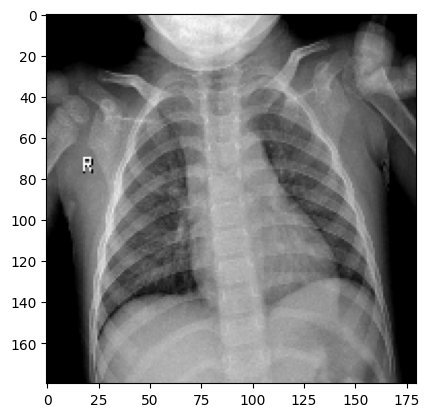

In [15]:
# 이미지 파일을 로드하는 함수
def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # 정규화
    return image

# 예시: train 데이터에서 이미지 파일을 가져오기
image_paths = tf.io.gfile.glob(TRAIN_PATH)
image = load_image(image_paths[0])

# 이미지 시각화
plt.imshow(image)
plt.show()

정상 이미지와 폐렴 이미지 구분(파일 경로 확인)

In [16]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/content/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0547-0001.jpeg
Pneumonia image path
/content/chest_xray/chest_xray/train/PNEUMONIA/person1454_bacteria_3782.jpeg


In [17]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [21]:
# 양성과 음성을 구분
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [20]:
# 이미지 형식 변경
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [24]:
# Create TensorFlow datasets from the filenames lists
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [25]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


 test 데이터셋 만들기

In [26]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [27]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 3. 데이터 시각화
---

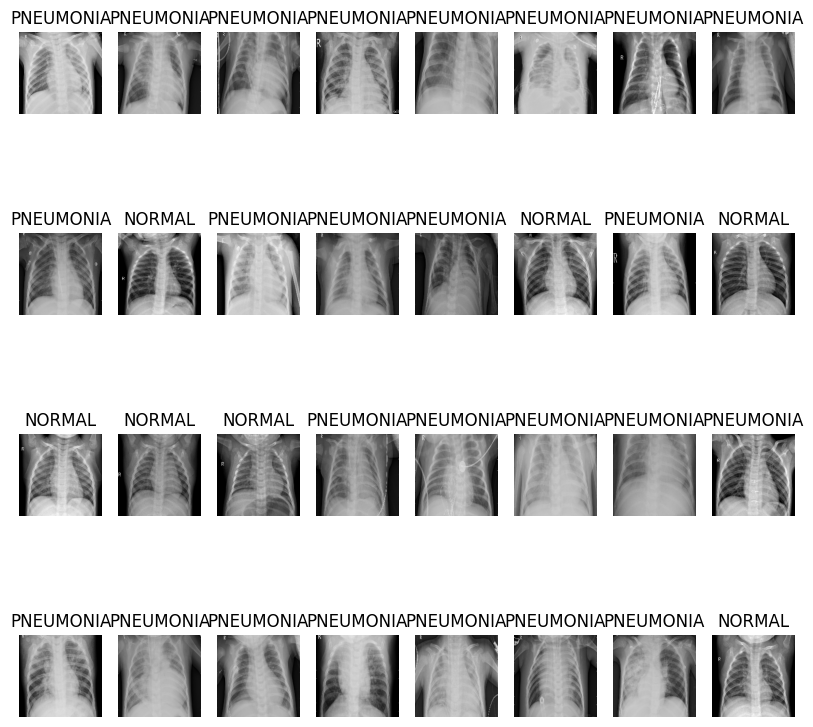

In [33]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    # Changed to len(image_batch) to iterate through actual batch size
    for n in range(len(image_batch)):
        ax = plt.subplot(4,math.ceil(len(image_batch)/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# 4. CNN 모델링
---

In [37]:
# Convolution block
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D() #Max Pooling
    ])

    return block

In [38]:
# Dense Block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [39]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

# 5. 데이터 imbalance 처리
---

In [46]:
# Calculate total number of training images
TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
VAL_IMG_COUNT = len(val_filenames)  # Add this line to define VAL_IMG_COUNT

# Now calculate the weights
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


# 6. 모델 훈련
---

In [42]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [51]:
# 데이터셋 로딩 시 label 값을 int로 변환하는 방법
def preprocess_image(image, label):
    # 이미지 전처리 (예: 크기 조정, 정규화 등)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = image / 255.0  # 0~255 범위를 0~1로 정규화

    # label 값을 int로 변환
    label = tf.cast(label, tf.int32)

    return image, label

# 데이터셋에 전처리 적용
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)

# 모델 학습
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 239s 3s/step - accuracy: 0.4909 - loss: 0.9121 - precision: 0.7407 - recall: 0.4954 - val_accuracy: 0.2461 - val_loss: 0.7114 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.5087 - loss: 0.8501 - precision: 0.7328 - recall: 0.5081 - val_accuracy: 0.2891 - val_loss: 0.7914 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.6863 - loss: 0.5123 - precision: 0.9299 - recall: 0.6369 - val_accuracy: 0.7344 - val_loss: 0.6849 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 4/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.8400 - loss: 0.3348 - precision: 0.9728 - recall: 0.8037 - val_accuracy: 0.7402 - val_loss: 0.5855 - val_precision: 0.7402 - val_recall: 1.0000
Epoch 5/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.8789 - loss: 0.2714 - precision: 0.9782 - recall: 0.8599 - val_accuracy: 0.7520 - v

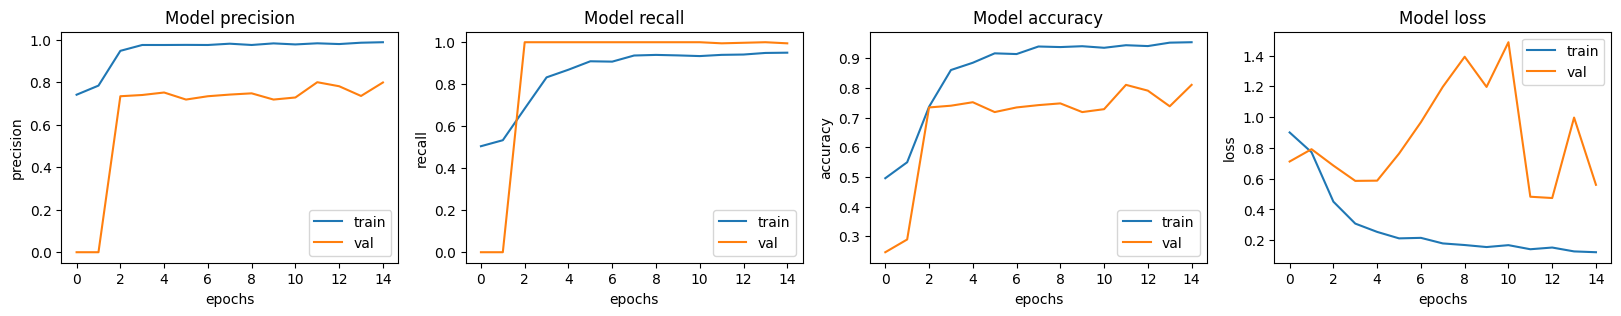

In [52]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [53]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 859ms/step - accuracy: 0.3749 - loss: 104.9744 - precision: 0.0000e+00 - recall: 0.0000e+00
Loss: 103.64935302734375,
Accuracy: 0.375,
Precision: 0.0,
Recall: 0.0


값이 말도 안되게 이상하게 나왔다.
정확도 37.5%, 손실 값은 104.9744.... 나머지는 0

노드에 있는 기존 베이스 모델 BATCH_SIZE = 16, EPOCHS = 10에서
BATCH_SIZE = 32, EPOCHS = 15 으로 조정만 했을 뿐인데 어째서지?
성능 향상하면서 다시 조정해봐야겠다.


# 7. 성능 향상 및 비교


In [63]:
# 0. 모델 정의
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.InputLayer(input_shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')  # 출력 클래스 10개
])

# 모델 요약
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 394272)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │      25,233,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,235,018 (96.26 MB)

 Trainable params: 25,235,018 (96.26 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# 1. 데이터 증강 강화
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)  # 좌우 반전
    image = tf.image.random_brightness(image, max_delta=0.2)  # 밝기 조절
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # 대비 조절
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2) # 채도 조절
    image = tf.image.random_hue(image, max_delta=0.1) # 색조 조절

    return image, label

In [65]:
# 2. 모델 조정
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.BatchNormalization(),  # 추가: Batch Normalization
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.3),  # 추가: Dropout
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # 추가: Dropout
        tf.keras.layers.Dense(1, activation='softmax')
    ])
    return model

In [67]:
# 3. 학습률 조정
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.0005

lr_scheduler = LearningRateScheduler(lr_schedule)

In [30]:
# 4. Class Weight 조정
class_weight = {
    0: 1.0,  # 정상 이미지 클래스 가중치
    1: 3.0   # 폐렴 이미지 클래스 가중치 (조정 가능)
}

In [59]:
# 5. 배치 크기 및 Epoch 조정
BATCH_SIZE = 16
EPOCHS = 10

In [35]:
train_dir = "/path/to/your/train_dataset"

In [51]:
# 6. Early Stopping
# 과적합을 방지하기 위해 Early Stopping 적용:

IMAGE_SIZE = (224, 224)
def preprocess_image(image, label):
    # 이미지 전처리 (예: 크기 조정, 정규화 등)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = image / 255.0  # 0~255 범위를 0~1로 정규화

    # label 값을 int로 변환
    label = tf.cast(label, tf.int32)

    return image, label

# Create TensorFlow datasets from the filenames lists (if not already created)
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# 데이터셋에 전처리 적용
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)

# 훈련 데이터셋과 검증 데이터셋의 이미지 수 계산
TRAIN_IMG_COUNT = sum(1 for _ in train_ds)  # train_ds에서 이미지 수 계산
VAL_IMG_COUNT = sum(1 for _ in val_ds)      # val_ds에서 이미지 수 계산

In [56]:
def process_path(file_path):
    # 이미지 로딩 및 전처리하는 코드
    pass

In [68]:
# Early Stopping 정의
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)

# 모델 컴파일
model.compile(
    optimizer='adam',  # Adam 옵티마이저 사용
    loss='sparse_categorical_crossentropy',  # 다중 클래스 분류의 손실 함수
    metrics=['accuracy']  # 정확도 지표
)

# 모델 훈련
history = model.fit(
    train_ds.batch(BATCH_SIZE),
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,  # 각 에포크마다 배치 처리
    epochs=EPOCHS,
    validation_data=val_ds.batch(BATCH_SIZE),
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,  # 검증 데이터셋 배치 처리
    class_weight=class_weight,
    callbacks=[early_stopping],
)

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 370s 1s/step - accuracy: 0.7284 - loss: 1.1261 - val_accuracy: 0.7375 - val_loss: 0.5954
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 577us/step - accuracy: 0.6667 - loss: 0.7725 - val_accuracy: 0.5714 - val_loss: 0.6081
Epoch 3/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


261/261 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.8626 - loss: 0.4217 - val_accuracy: 0.9135 - val_loss: 0.2099
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 1.0000 - loss: 0.1459 - val_accuracy: 1.0000 - val_loss: 0.0287
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 356s 1s/step - accuracy: 0.9214 - loss: 0.2620 - val_accuracy: 0.9173 - val_loss: 0.2189
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 1.0000 - loss: 0.0766 - val_accuracy: 1.0000 - val_loss: 0.0075
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 353s 1s/step - accuracy: 0.9341 - loss: 0.2293 - val_accuracy: 0.9154 - val_loss: 0.2389
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 1.0000 - loss: 0.0522 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 9/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.9418 - loss: 0.2168 - val_accuracy: 0.9087 - val_loss: 0.2696
Epoch 10/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step - accuracy: 1.0000 - loss: 0.0499 - val_accuracy: 

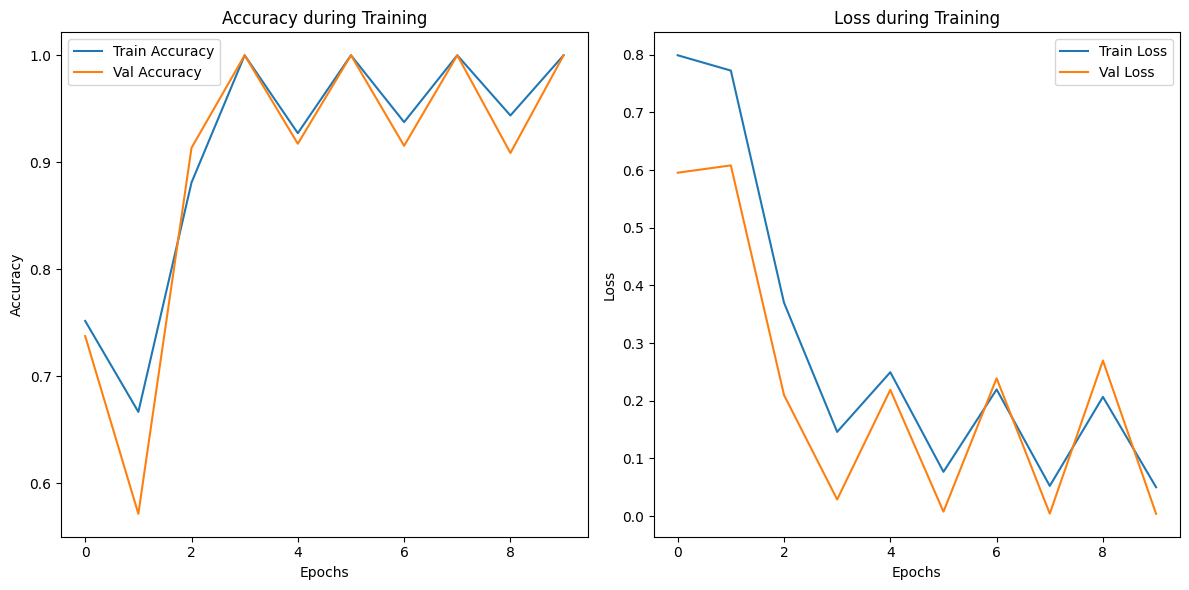

In [72]:
# 훈련 정확도와 검증 정확도
plt.figure(figsize=(12, 6))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy during Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 그래프 출력
plt.tight_layout()
plt.show()

In [73]:
# 훈련 중 손실, 정확도, 정밀도, 재현율 출력
print("훈련 중 기록:")
print(f"훈련 정확도: {history.history['accuracy']}")
print(f"훈련 손실: {history.history['loss']}")
if 'precision' in history.history:
    print(f"훈련 정밀도: {history.history['precision']}")
if 'recall' in history.history:
    print(f"훈련 재현율: {history.history['recall']}")

print("\n검증 중 기록:")
print(f"검증 정확도: {history.history['val_accuracy']}")
print(f"검증 손실: {history.history['val_loss']}")
if 'val_precision' in history.history:
    print(f"검증 정밀도: {history.history['val_precision']}")
if 'val_recall' in history.history:
    print(f"검증 재현율: {history.history['val_recall']}")

훈련 중 기록:
훈련 정확도: [0.7516762614250183, 0.6666666865348816, 0.8809865713119507, 1.0, 0.9272030591964722, 1.0, 0.9375, 1.0, 0.9437260627746582, 1.0]
훈련 손실: [0.7990868091583252, 0.7724944353103638, 0.37000006437301636, 0.14592665433883667, 0.24941521883010864, 0.0766429528594017, 0.21954643726348877, 0.05223700404167175, 0.20664826035499573, 0.04992347210645676]

검증 중 기록:
검증 정확도: [0.737500011920929, 0.5714285969734192, 0.9134615659713745, 1.0, 0.9173076748847961, 1.0, 0.9153845906257629, 1.0, 0.9086538553237915, 1.0]
검증 손실: [0.5953903198242188, 0.6080752611160278, 0.209902822971344, 0.028699513524770737, 0.21892805397510529, 0.007507503032684326, 0.2388777881860733, 0.004145772196352482, 0.2695826590061188, 0.0038705910556018353]


In [80]:
# 모델 컴파일
model.compile(
    optimizer='adam',  # Adam 옵티마이저 사용
    loss='sparse_categorical_crossentropy',  # 다중 클래스 분류의 손실 함수
    metrics=['accuracy', Precision(), Recall()]  # 정확도, Precision, Recall 추가
)

훈련 기록:
훈련 정확도는 0.75에서 시작하여 1.0에 가까운 값으로 올라갔다. 모델이 훈련 데이터에 대해서 매우 잘 맞추고 있다.
훈련 손실은 훈련이 진행될수록 빠르게 감소하며, 0.05 이하로 매우 낮은 값을 보였다.

---

검증 기록:
검증 정확도는 0.74에서 시작해 최고 1.0에 도달하며, 훈련과 비슷하게 상승하는 경향을 보인다. 모델이 검증 데이터에 대해서도 잘 일반화되는 것을 보여주었다.
검증 손실은 매우 낮은 값으로, 특히 마지막 에포크에서 0.0038로 매우 작은 값에 도달했다. 검증 데이터에서 오차를 거의 없애며 잘 예측하고 있다.

---
기존 베이스 모델보다 성능이 많이 향상되었다! 신기하다

그러나,  Precision()와 Recall() 값을 추가하는 것을 까먹었다..ResNet-18 모델도 구현해야 한다

갈길이 멀다..........

#8. ResNet-18 모델

In [102]:
# 이미지 파일 경로에서 이미지와 레이블을 로드하는 함수
def process_path(file_path):
    # 파일 경로에서 이미지 파일 읽기
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)  # 이미지 디코딩
    label = get_label_from_filename(file_path)

    return image, label
def get_label_from_filename(file_path):
    class_names = ['class1', 'class2']
    label = tf.strings.regex_replace(file_path, '.*\\/|\\..*', '')
    label = tf.strings.to_number(label, tf.int32)
    return label


In [96]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import matplotlib.pyplot as plt
import os
import zipfile

# Residual Block 정의
def residual_block(x, filters, stride=1):
    shortcut = x

    # 첫 번째 Convolution Layer
    x = layers.Conv2D(filters, (3, 3), strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 두 번째 Convolution Layer
    x = layers.Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # 스킵 연결 (shortcut)
    if stride != 1:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # 스킵 연결 추가
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)

    return x

# ResNet-18 모델 정의
def build_resnet18():
    input = layers.Input(shape=(224, 224, 3))

    # Initial Conv Layer
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Residual Blocks
    x = residual_block(x, 64, stride=1)
    x = residual_block(x, 64, stride=1)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128, stride=1)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256, stride=1)

    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512, stride=1)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Fully Connected Layer
    x = layers.Dense(10, activation='softmax')(x)  # 10개의 클래스를 예측 (폐렴 분류 포함)

    model = models.Model(inputs=input, outputs=x)

    return model

# 이미지 파일 경로에서 레이블을 추출하는 함수
def process_path(file_path):
    # 파일 경로에서 이미지 파일 읽기
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)  # 이미지 디코딩

    # 레이블 추출 (파일 이름에 따라)
    label = get_label_from_filename(file_path)

    return image, label

# 파일 이름에서 레이블을 추출하는 함수 (파일 이름에서 'NORMAL' 또는 'PNEUMONIA'를 추출)
def get_label_from_filename(file_path):
    # 파일 이름에서 클래스 정보를 추출 (예: 'NORMAL2-IM-0547-0001.jpeg' -> 'NORMAL')
    base_name = os.path.basename(file_path)  # 'NORMAL2-IM-0547-0001.jpeg'
    label_name = base_name.split('-')[0]  # 'NORMAL' 또는 'PNEUMONIA'

    # 레이블을 숫자로 변환 ('NORMAL' -> 0, 'PNEUMONIA' -> 1)
    if label_name == 'NORMAL':
        return 0
    else:
        return 1

# 데이터 증강 정의
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    return image, label

# 데이터 전처리 함수
IMAGE_SIZE = (224, 224)

def preprocess_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = image / 255.0  # 정규화
    label = tf.cast(label, tf.int32)
    return image, label

# 배치 크기와 epoch 설정
BATCH_SIZE = 16
EPOCHS = 10

# Kaggle API를 통해 데이터셋 다운로드
os.makedirs('/root/.kaggle', exist_ok=True)  # .kaggle 디렉토리 생성
!mv kaggle.json /root/.kaggle/  # 파일 이동
!chmod 600 /root/.kaggle/kaggle.json  # 보안 권한 설정
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('chest_xray')  # 'chest_xray' 디렉토리에 압축 해제

# chest_xray 경로 내 데이터 경로 설정
ROOT_PATH = '/content/chest_xray/chest_xray'  # 수정된 부분: 압축 해제된 폴더 경로를 지정
TRAIN_PATH = os.path.join(ROOT_PATH, 'train', '*/*')  # train 폴더 내 모든 이미지
VAL_PATH = os.path.join(ROOT_PATH, 'val', '*/*')      # val 폴더 내 모든 이미지
TEST_PATH = os.path.join(ROOT_PATH, 'test', '*/*')    # test 폴더 내 모든 이미지

train_filenames = tf.io.gfile.glob(TRAIN_PATH)  # train 이미지 파일 경로 가져오기
val_filenames = tf.io.gfile.glob(VAL_PATH)      # val 이미지 파일 경로 가져오기

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7cd7af549750>
Traceback (most recent call last):
  File "/usr/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [98]:
# 파일 경로에서 레이블을 추출하는 함수
def get_label_from_filename(file_path):
    # 텐서에서 문자열을 추출
    file_path = tf.strings.regex_replace(file_path, '.*/', '')  # 폴더 경로 제거하여 파일명만 추출

    # 파일 이름에서 레이블 추출 (예: NORMAL2-IM-0547-0001.jpeg)
    label = tf.cond(
        tf.strings.regex_full_match(file_path, '.*NORMAL.*'),
        lambda: 0,  # 정상 클래스
        lambda: 1   # 폐렴 클래스
    )
    return label

# 파일 경로에서 이미지를 로드하고 레이블을 추출하는 함수
def process_path(file_path):
    label = get_label_from_filename(file_path)

    # 이미지를 로드하고 전처리 (이미지 읽기, 리사이즈 등)
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # 이미지 크기 맞추기

    return image, label

# 데이터셋 경로 설정
train_list_ds = tf.data.Dataset.list_files(TRAIN_PATH, shuffle=False)
val_list_ds = tf.data.Dataset.list_files(VAL_PATH, shuffle=False)

# 데이터셋에 전처리 적용
train_ds = train_list_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

# 데이터셋 배치 및 증강 적용
train_ds = train_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

# 훈련 이미지와 검증 이미지 개수 (개수 계산을 위해 데이터를 한 번 반복)
TRAIN_IMG_COUNT = len(list(train_ds))  # 데이터셋을 리스트로 변환하여 길이 계산
VAL_IMG_COUNT = len(list(val_ds))      # 데이터셋을 리스트로 변환하여 길이 계산

In [99]:
# 모델 생성
model = build_resnet18()

# 모델 요약
model.summary()

# 모델 컴파일
model.compile(
    optimizer='adam',  # Adam 옵티마이저 사용
    loss='sparse_categorical_crossentropy',  # 다중 클래스 분류의 손실 함수
    metrics=['accuracy']  # 정확도 지표
)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# LearningRateScheduler 설정
def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.0005

lr_scheduler = LearningRateScheduler(lr_schedule)

# 모델 훈련
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    callbacks=[early_stopping, lr_scheduler]
)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_69 (Conv2D)        │ (None, 112, 112, 64)   │          9,472 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_60    │ (None, 112, 112, 64)   │            256 │ conv2d_69[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_51 (ReLU)           │ (None, 112, 112, 64)   │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 56, 56, 64)     │              0 │ re_lu_51[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_70 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_61    │ (None, 56, 56, 64)     │            256 │ conv2d_70[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_52 (ReLU)           │ (None, 56, 56, 64)     │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_71 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ re_lu_52[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_62    │ (None, 56, 56, 64)     │            256 │ conv2d_71[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_24 (Add)              │ (None, 56, 56, 64)     │              0 │ batch_normalization_6… │
│                           │                        │                │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_53 (ReLU)           │ (None, 56, 56, 64)     │              0 │ add_24[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_72 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ re_lu_53[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_63    │ (None, 56, 56, 64)     │            256 │ conv2d_72[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_54 (ReLU)           │ (None, 56, 56, 64)     │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_73 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ re_lu_54[0][0]         │
├──────────────────────

 Total params: 11,196,042 (42.71 MB)

 Trainable params: 11,186,442 (42.67 MB)

 Non-trainable params: 9,600 (37.50 KB)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 130s 6s/step - accuracy: 0.8105 - loss: 0.3900 - val_accuracy: 0.0000e+00 - val_loss: 224.1812 - learning_rate: 0.0010
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 111s 6s/step - accuracy: 0.9812 - loss: 0.1962 - val_accuracy: 0.0000e+00 - val_loss: 193.4375 - learning_rate: 0.0010
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 122s 6s/step - accuracy: 0.8806 - loss: 0.2056 - val_accuracy: 0.0000e+00 - val_loss: 517.0786 - learning_rate: 0.0010
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 111s 6s/step - accuracy: 1.0000 - loss: 1.7120e-04 - val_accuracy: 0.0000e+00 - val_loss: 78.3822 - learning_rate: 0.0010
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 113s 6s/step - accuracy: 0.7371 - loss: 2.0094 - val_accuracy: 0.0000e+00 - val_loss: 1997.2312 - learning_rate: 0.0010
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 117s 6s/step - accuracy: 1.0000 - loss: 6.0230e-04 - val_accuracy: 0.0000e+00 - val_loss: 368.7976 - learning_rate: 0.0010
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 137s 7s/step

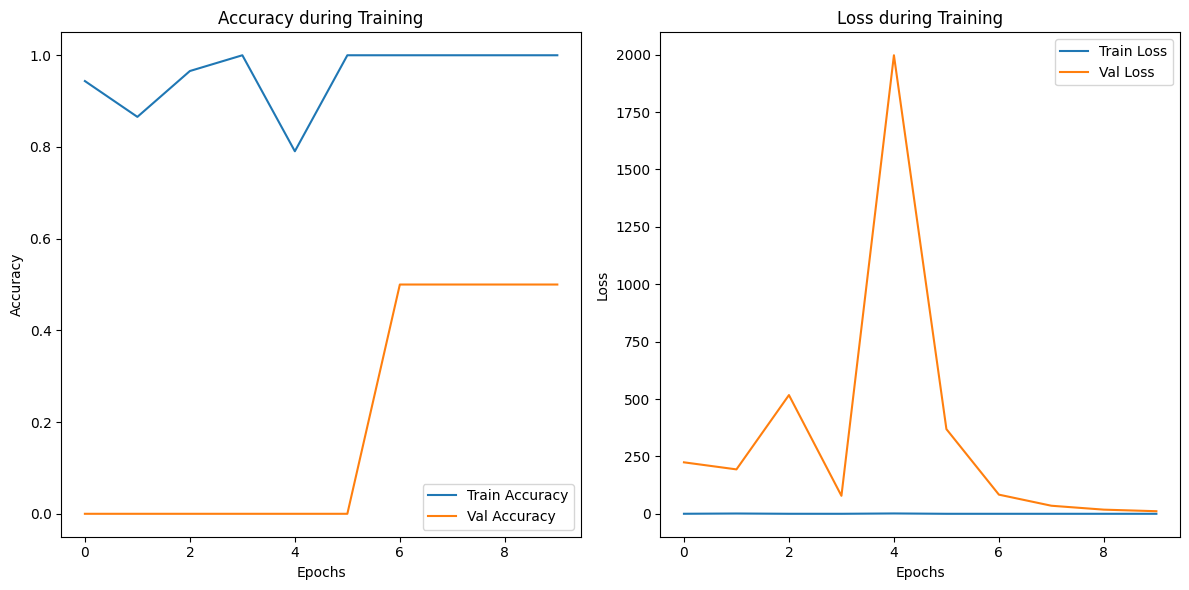

In [100]:
# 훈련 정확도와 검증 정확도 시각화
plt.figure(figsize=(12, 6))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy during Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [101]:
# 훈련 결과 출력
print("훈련 종료 후 결과:")
print(f"최종 훈련 정확도: {history.history['accuracy'][-1]:.4f}")
print(f"최종 검증 정확도: {history.history['val_accuracy'][-1]:.4f}")
print(f"최종 훈련 손실: {history.history['loss'][-1]:.4f}")
print(f"최종 검증 손실: {history.history['val_loss'][-1]:.4f}")

# 각 에폭의 훈련 정확도와 검증 정확도 출력
print("\n각 에폭의 훈련 정확도와 검증 정확도:")
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"훈련 정확도: {history.history['accuracy'][epoch]:.4f}, 검증 정확도: {history.history['val_accuracy'][epoch]:.4f}")
    print(f"훈련 손실: {history.history['loss'][epoch]:.4f}, 검증 손실: {history.history['val_loss'][epoch]:.4f}")


훈련 종료 후 결과:
최종 훈련 정확도: 1.0000
최종 검증 정확도: 0.5000
최종 훈련 손실: 0.0001
최종 검증 손실: 11.2566

각 에폭의 훈련 정확도와 검증 정확도:
Epoch 1/10
훈련 정확도: 0.9438, 검증 정확도: 0.0000
훈련 손실: 0.1184, 검증 손실: 224.1812
Epoch 2/10
훈련 정확도: 0.8656, 검증 정확도: 0.0000
훈련 손실: 1.2517, 검증 손실: 193.4375
Epoch 3/10
훈련 정확도: 0.9656, 검증 정확도: 0.0000
훈련 손실: 0.0609, 검증 손실: 517.0786
Epoch 4/10
훈련 정확도: 1.0000, 검증 정확도: 0.0000
훈련 손실: 0.0001, 검증 손실: 78.3822
Epoch 5/10
훈련 정확도: 0.7906, 검증 정확도: 0.0000
훈련 손실: 1.4846, 검증 손실: 1997.2312
Epoch 6/10
훈련 정확도: 1.0000, 검증 정확도: 0.0000
훈련 손실: 0.0004, 검증 손실: 368.7976
Epoch 7/10
훈련 정확도: 1.0000, 검증 정확도: 0.5000
훈련 손실: 0.0002, 검증 손실: 83.3972
Epoch 8/10
훈련 정확도: 1.0000, 검증 정확도: 0.5000
훈련 손실: 0.0001, 검증 손실: 35.0860
Epoch 9/10
훈련 정확도: 1.0000, 검증 정확도: 0.5000
훈련 손실: 0.0001, 검증 손실: 18.0347
Epoch 10/10
훈련 정확도: 1.0000, 검증 정확도: 0.5000
훈련 손실: 0.0001, 검증 손실: 11.2566


과적합으로 훈련 데이터에만 최적화된 모델이 되어버렸다.

### 모델 조정

In [106]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import os
import zipfile

# Residual Block 정의
def residual_block(x, filters, stride=1):
    shortcut = x

    # 첫 번째 Convolution Layer
    x = layers.Conv2D(filters, (3, 3), strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 두 번째 Convolution Layer
    x = layers.Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # 스킵 연결 (shortcut)
    if stride != 1:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # 스킵 연결 추가
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)

    return x

# ResNet-18 모델 정의
def build_resnet18():
    input = layers.Input(shape=(224, 224, 3))

    # Initial Conv Layer
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Residual Blocks
    x = residual_block(x, 64, stride=1)
    x = residual_block(x, 64, stride=1)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128, stride=1)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256, stride=1)

    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512, stride=1)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Fully Connected Layer
    x = layers.Dense(10, activation='softmax')(x)  # 10개의 클래스를 예측 (폐렴 분류 포함)

    model = models.Model(inputs=input, outputs=x)

    return model

# 이미지 파일 경로에서 레이블을 추출하는 함수
def get_label_from_filename(file_path):
    # 파일 이름에서 클래스 정보를 추출 (예: 'NORMAL2-IM-0547-0001.jpeg' -> 'NORMAL')
    base_name = os.path.basename(file_path)  # 'NORMAL2-IM-0547-0001.jpeg'
    label_name = base_name.split('-')[0]  # 'NORMAL' 또는 'PNEUMONIA'

    # 레이블을 숫자로 변환 ('NORMAL' -> 0, 'PNEUMONIA' -> 1)
    if label_name == 'NORMAL':
        return 0
    else:
        return 1

# 이미지 파일 경로에서 이미지를 로드하고 레이블을 추출하는 함수
def process_path(file_path):
    label = get_label_from_filename(file_path)  # 레이블 추출

    # 이미지를 로드하고 전처리 (이미지 읽기, 리사이즈 등)
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # 이미지 크기 맞추기

    return image, label

# 데이터 증강 정의
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    return image, label

# 데이터 전처리 함수
IMAGE_SIZE = (224, 224)

def preprocess_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = image / 255.0  # 정규화
    label = tf.cast(label, tf.int32)
    return image, label

# 배치 크기와 epoch 설정
BATCH_SIZE = 16
EPOCHS = 10

# Kaggle API를 통해 데이터셋 다운로드
os.makedirs('/root/.kaggle', exist_ok=True)  # .kaggle 디렉토리 생성
!mv kaggle.json /root/.kaggle/  # 파일 이동
!chmod 600 /root/.kaggle/kaggle.json  # 보안 권한 설정
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('chest_xray')  # 'chest_xray' 디렉토리에 압축 해제

# chest_xray 경로 내 데이터 경로 설정
ROOT_PATH = '/content/chest_xray/chest_xray'  # 수정된 부분: 압축 해제된 폴더 경로를 지정
TRAIN_PATH = os.path.join(ROOT_PATH, 'train', '*/*')  # train 폴더 내 모든 이미지
VAL_PATH = os.path.join(ROOT_PATH, 'val', '*/*')      # val 폴더 내 모든 이미지
TEST_PATH = os.path.join(ROOT_PATH, 'test', '*/*')    # test 폴더 내 모든 이미지

train_filenames = tf.io.gfile.glob(TRAIN_PATH)  # train 이미지 파일 경로 가져오기
val_filenames = tf.io.gfile.glob(VAL_PATH)      # val 이미지 파일 경로 가져오기

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [114]:
# 이미지 파일 경로에서 이미지를 로드하고 레이블을 추출하는 함수
def process_path(file_path):
    label = get_label_from_filename(file_path)  # 레이블 추출

    # 이미지를 로드하고 전처리 (이미지 읽기, 리사이즈 등)
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # 이미지 크기 맞추기

    image = image / 255.0  # 정규화
    label = tf.cast(label, tf.int32)  # 레이블을 텐서로 변환

    return image, label

# 파일 경로에서 레이블을 추출하는 함수
def get_label_from_filename(file_path):
    # 텐서에서 문자열을 추출
    file_path = tf.strings.regex_replace(file_path, '.*/', '')  # 폴더 경로 제거하여 파일명만 추출

    # 파일 이름에서 레이블 추출 (예: NORMAL2-IM-0547-0001.jpeg)
    label = tf.cond(
        tf.strings.regex_full_match(file_path, '.*NORMAL.*'),
        lambda: 0,  # 정상 클래스
        lambda: 1   # 폐렴 클래스
    )
    return label

# 데이터셋에 전처리 적용
train_ds = train_list_ds.map(lambda x: process_path(x), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_list_ds.map(lambda x: process_path(x), num_parallel_calls=tf.data.AUTOTUNE)

# 데이터셋 배치 및 증강 적용
train_ds = train_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

# 훈련 이미지와 검증 이미지 개수 (개수 계산을 위해 데이터를 한 번 반복)
TRAIN_IMG_COUNT = len(list(train_ds))  # 데이터셋을 리스트로 변환하여 길이 계산
VAL_IMG_COUNT = len(list(val_ds))      # 데이터셋을 리스트로 변환하여 길이 계산

In [115]:
# 모델 생성
model = build_resnet18()

# 모델 컴파일
model.compile(
    optimizer='adam',  # Adam 옵티마이저 사용
    loss='sparse_categorical_crossentropy',  # 다중 클래스 분류의 손실 함수
    metrics=['accuracy']  # 정확도 지표
)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# LearningRateScheduler 설정
def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.0005

lr_scheduler = LearningRateScheduler(lr_schedule)

# 모델 훈련
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 138s 6s/step - accuracy: 0.5399 - loss: 2.6736 - val_accuracy: 0.5000 - val_loss: 221.2428 - learning_rate: 0.0010
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 128s 6s/step - accuracy: 0.5426 - loss: 0.7395 - val_accuracy: 0.5000 - val_loss: 484.0380 - learning_rate: 0.0010
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 111s 6s/step - accuracy: 0.5162 - loss: 0.7393 - val_accuracy: 0.5000 - val_loss: 92.0978 - learning_rate: 0.0010
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 112s 6s/step - accuracy: 0.5716 - loss: 0.7260 - val_accuracy: 0.5000 - val_loss: 16.3733 - learning_rate: 0.0010
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 108s 5s/step - accuracy: 0.6794 - loss: 0.5147 - val_accuracy: 0.5000 - val_loss: 6.6000 - learning_rate: 0.0010
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 112s 6s/step - accuracy: 1.0000 - loss: 1.7772e-04 - val_accuracy: 0.5000 - val_loss: 6.7350 - learning_rate: 0.0010
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 107s 5s/step - accuracy: 1.0000 - loss: 3.4935

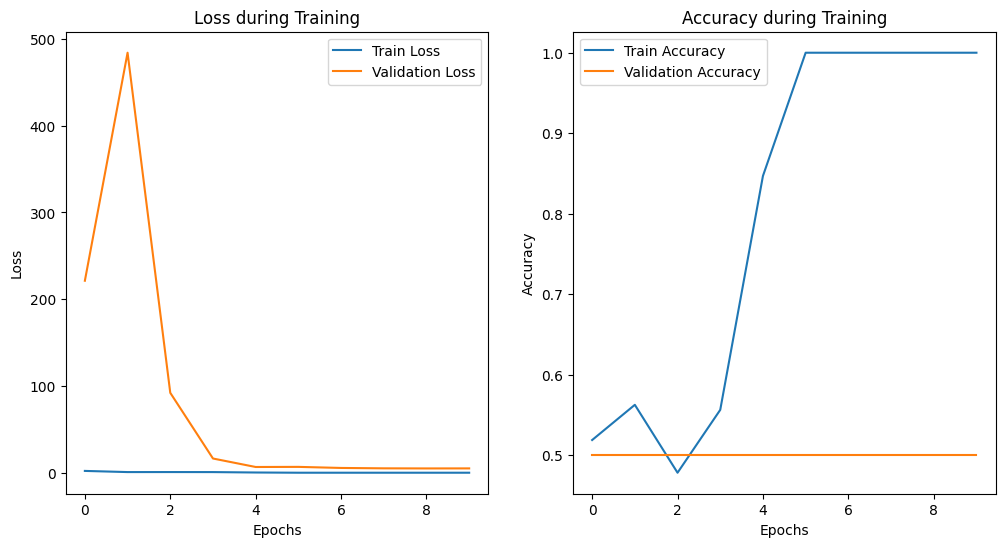

최종 훈련 정확도: 1.0000
최종 검증 정확도: 0.5000
최종 훈련 손실: 0.0000
최종 검증 손실: 4.9861


In [116]:
import matplotlib.pyplot as plt

# 훈련 후 history 객체에서 손실 값과 정확도 가져오기
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# 훈련 손실 그래프
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 훈련 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy during Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 훈련 종료 후 최종 결과 출력
print(f"최종 훈련 정확도: {train_acc[-1]:.4f}")
print(f"최종 검증 정확도: {val_acc[-1]:.4f}")
print(f"최종 훈련 손실: {train_loss[-1]:.4f}")
print(f"최종 검증 손실: {val_loss[-1]:.4f}")

아직도... 과적합이다

In [130]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout, Flatten, Dense

# 하이퍼파라미터 설정
BATCH_SIZE = 32
EPOCHS = 20
TRAIN_IMG_COUNT = 1000  # 훈련 이미지 개수 (예시)
VAL_IMG_COUNT = 200    # 검증 이미지 개수 (예시)

# 이미지 전처리 함수
def process_path(file_path):
    label = get_label_from_filename(file_path)  # 레이블 추출

    # 이미지를 로드하고 전처리 (이미지 읽기, 리사이즈 등)
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # 이미지 크기 맞추기

    image = image / 255.0  # 정규화
    label = tf.cast(label, tf.int32)  # 레이블을 텐서로 변환

    return image, label

# 드롭아웃 추가
from tensorflow.keras.layers import Dropout

def build_resnet18():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),  # 드롭아웃 추가
        Dense(1, activation='sigmoid')  # Output layer changed for binary classification
    ])

    return model

In [18]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout, Flatten, Dense

# 하이퍼파라미터 설정
BATCH_SIZE = 32
EPOCHS = 20
TRAIN_IMG_COUNT = 1000  # 훈련 이미지 개수 (예시)
VAL_IMG_COUNT = 200    # 검증 이미지 개수 (예시)

# 이미지 전처리 함수
def process_path(file_path):
    label = get_label_from_filename(file_path)  # 레이블 추출

    # 이미지를 로드하고 전처리 (이미지 읽기, 리사이즈 등)
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # 이미지 크기 맞추기

    image = image / 255.0  # 정규화
    label = tf.cast(label, tf.int32)  # 레이블을 텐서로 변환

    return image, label

# 드롭아웃 추가
from tensorflow.keras.layers import Dropout

def build_resnet18():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),  # 드롭아웃 추가
        Dense(1, activation='sigmoid')  # Output layer changed for binary classification
    ])

    return model

# 다양한 데이터 증강 기법 추가
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_saturation(image, lower=0.2, upper=1.8)

    return image, label

# 훈련 데이터에 증강 적용
train_ds = train_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

# 모델 컴파일 시 메트릭스 추가
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# 모델 컴파일
model = build_resnet18()

model.compile(
    optimizer='adam',  # Adam 옵티마이저 사용
    loss='binary_crossentropy',  # Loss function changed for binary classification
    metrics=METRICS  # 메트릭스에 precision과 recall 추가
)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# LearningRateScheduler 설정
def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.0005

lr_scheduler = LearningRateScheduler(lr_schedule)

# 모델 훈련
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    callbacks=[early_stopping, lr_scheduler]
)


NameError: name 'train_ds' is not defined

#회고
---

처음에 데이터를 로드하는 과정에서 경로를 올바르게 입력하지 않아서 데이터가 자꾸 0으로 떠서 고생하였다. 메인 퀘스트를 벌써 두 번째 진행하는 건데 아직도 어려운 것 같다.


모델 학습에서도 여러가지 문제를 겪었는데 다 기록하면 너무 길어져서 최대한 깔끔하게 작성하려고 노력했다.그리고 데이터의 수가 많아지다 보니 점점 에폭을 기다리는 시간이 오래 걸려서 힘들었던 것 같다.


그리고 마지막에 ResNet-18모델을 구현하긴 했는데 학습이 제대로 이루어지지 못한 것 같다. 과적합을 해결하지 못했다... 시간상의 문제로 (런타임 끊김)더 진행할 수 없었는데 아쉽다.


 그래도 어찌저찌 시간 내 다 학습시켜 다행이었다. 다음 메인 퀘스트에는 이것보다 성장했으면 좋겠다!
